In [1]:

#import matplotlib.pyplot as plt
import os
import torch
from src.rgcn_explainer_utils import *
import pandas as pd
import numpy as np
import src.kgbench as kg

/usr/local/Caskroom/miniconda/base/envs/RGCNExplainer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get the current directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Check if the current directory is already the parent directory
if current_dir != '/Users/macoftraopia/Documents/GitHub/RGCN-Explainer':
    # Set the parent directory as the current directory
    os.chdir(parent_dir)
!pwd

/Users/macoftraopia/Documents/GitHub/RGCN-Explainer


In [ ]:
# filename = 'data/IMDB/imdb_onegenre.nt'
# output_filename = 'data/IMDB/imdb_onegenre_.nt'
# literal_rel = pd.read_csv('IMDB_relation_literal.csv')
# literal_rel = literal_rel['relation'].tolist()

# with open(filename, 'r') as file, open(output_filename, 'w') as output:
#     for line in file:
#         for i in literal_rel:
#          if i not in line:
#             output.write(line)
# literal_rel = pd.read_csv('IMDB_relation_literal.csv')
# literal_rel = literal_rel['relation'].tolist()
# print(literal_rel)

ordered dict {6894: 'Publikationen', 5851: 'Personen', 7140: 'Publikationen', 5857: 'Personen', 7258: 'Publikationen', 5865: 'Personen', 5682: 'Personen', 0: 'blank', 5695: 'Personen', 5707: 'Personen', 5731: 'Personen', 5748: 'Personen', 5862: 'Personen', 5870: 'Personen', 5894: 'Personen', 5388: 'Forschungsgebiete', 5935: 'Projekte', 5753: 'Personen', 5693: 'Personen', 5703: 'Personen', 5758: 'Personen', 5780: 'Personen', 5798: 'Personen', 5768: 'Personen', 5917: 'Projekte'}
dict node color {6894: 5426, 5851: 5423, 7140: 5426, 5857: 7, 7258: 5426, 5865: 5423, 5682: 5423, 0: 0, 5695: 5423, 5707: 5423, 5731: 5423, 5748: 5423, 5862: 5423, 5870: 5423, 5894: 5423, 5388: 5419, 5935: 5424, 5753: 5423, 5693: 5423, 5703: 5423, 5758: 5423, 5780: 5423, 5798: 5423, 5768: 5423, 5917: 5424}
colors [(1.0, 0.1296454183688629, 0.0, 1.0), (1.0, 0.1296454183688629, 0.0, 1.0), (0.042511102674156365, 0.7408012703641469, 0.2247245592882939, 1.0), (0.2280405192384154, 0.9359470417164775, 0.0, 1.0), (1.0, 0

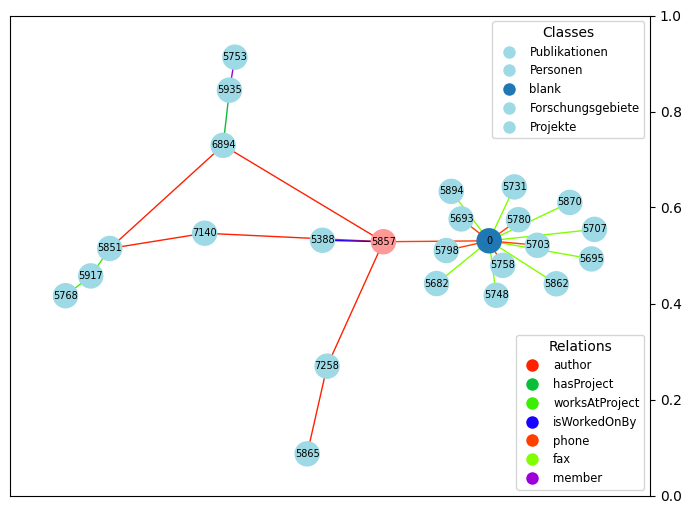

<Figure size 640x480 with 0 Axes>

In [113]:

from matplotlib import legend
from networkx import spring_layout


def connect_minimally(disconnected_triples, guideline_triples):
    G = nx.Graph()

    # Add the disconnected triples as edges to the graph
    for u,label, v in disconnected_triples:
        G.add_edge(int(u), int(v), weight=label)

    # Check if the graph is connected
    is_connected = nx.is_connected(G)
    # If the graph is not connected
    if not is_connected:
        # Get the nodes from the disconnected triples
        disconnected_nodes = set()
        for triple in disconnected_triples:
            disconnected_nodes.add(triple[0])
            disconnected_nodes.add(triple[1])

        # Create a subgraph with only the guideline triples relevant to the disconnected nodes
        subgraph = nx.Graph()
        for u,label, v in guideline_triples:
            if u in disconnected_nodes and v in disconnected_nodes:
                subgraph.add_edge(int(u), int(v), weight=label)
            


        # Compute the minimum spanning tree of the subgraph
        min_spanning_tree = nx.minimum_spanning_tree(subgraph)

        # Add the edges from the minimum spanning tree to the graph
        for u, v, weight in min_spanning_tree.edges(data='weight'):
            G.add_edge(u, v, weight=weight)



    return G


def visualize(node_idx, n_hop, data, masked_ver,masked_hor,threshold,name, result_weights=True, low_threshold=False,experiment_name=None, selected_visualization=True, connected_subgraph = True,make_connected=False):
    """ 
    Visualize important nodes for node idx prediction
    """
    get_relations(data)
    #dict_index = dict_index_classes(data,masked_ver) + dict_index_classes(data,masked_hor)
    #dict_index = {**dict_index_classes(data,masked_ver), **dict_index_classes(data,masked_hor)}
    #print(set(list(dict_index.values())))
    #select only nodes with a certain threshold
    if selected_visualization:
        sel_masked_ver, sel_masked_hor = sub_sparse_tensor(masked_ver, threshold,data, low_threshold),sub_sparse_tensor(masked_ver, threshold,data, low_threshold)

    else:
        sel_masked_ver, sel_masked_hor = masked_ver, masked_ver
    if len(sel_masked_ver)==0:
        sel_masked_ver=sub_sparse_tensor(masked_ver, 0,data, low_threshold)
    indices_nodes = sel_masked_ver.coalesce().indices().detach().numpy()
    
    G = nx.Graph()
    if result_weights: #the edge value is the mask weight       
        G.add_edges_from([(int(s), int(o), {'weight': np.round(p, 2)}) for s, p, o in zip(indices_nodes[0], sel_masked_ver.coalesce().values().tolist(), indices_nodes[1])])

    else: #the edge value is the relation
        triples_matched = match_to_triples(sel_masked_ver,sel_masked_hor, data)
        G.add_edges_from([(int(s), int(o), {'weight': p}) for s, p, o in find_repeating_sublists(triples_matched.tolist())])

    if connected_subgraph:
        G = G.subgraph(next(comp for comp in nx.connected_components(G) if node_idx in comp))

    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = [list(set([item] if not isinstance(item, list) else item)) for item in weights]


    #ordered_dict = {int(node): str(data.i2e[int(node)]).split('/')[3] for node in G.nodes if '#' not in str(data.i2e[int(node)]).split('/')[3] else str(data.i2e[int(node)]).split('/')[3][1].split('#')[1].split(',')[0].replace("'","")}
    #ordered_dict = {int(node): str(data.i2e[int(node)]).split('/')[3] if 'http' in str(data.i2e[int(node)])  else 'blank' for node in G.nodes}
    if name == 'IMDb_us':
        ordered_dict = {
            int(node): (
                str(data.i2e[int(node)]).split('/')[6].split(',')[0]
                # str(data.i2e[int(node)]).split('/')[6].split('#')[0]
                # if 'http' in str(data.i2e[int(node)]) and '#' in str(data.i2e[int(node)])
                # else str(data.i2e[int(node)]).split('/')[6]
                # if 'http' in str(data.i2e[int(node)])
                # else 'blank'
                    )
            for node in G.nodes
            }
    else:

        ordered_dict = {
        int(node): (
            str(data.i2e[int(node)]).split('/')[3].split('#')[0]
            if 'http' in str(data.i2e[int(node)]) and '#' in str(data.i2e[int(node)])
            else str(data.i2e[int(node)]).split('/')[3]
            if 'http' in str(data.i2e[int(node)])
            else 'blank'
        )
        for node in G.nodes
        }


    dict_node_color = {k: data.entities_classes[v] if v in data.entities_classes else 0 for k, v in ordered_dict.items()} 
    dict_node_color[node_idx] = 7
    print('dict node color',dict_node_color)
    labeldict = {int(node): int(node) for node in G.nodes}

    pos = nx.circular_layout(G)
    if make_connected:
        disconnected_triples = [[i[0], j[0], i[1]] for i, j in zip(edges, weights)] + [[i[0], j[1], i[1]] for i, j in zip(edges, weights) if len(j) > 1]; guideline_triples = data.triples.tolist()
        G = connect_minimally(disconnected_triples, guideline_triples)
        #G = G.subgraph(next(comp for comp in nx.connected_components(G) if node_idx in comp))
        G = G.subgraph(next(comp for comp in nx.connected_components(G)))
        edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
        labeldict = {int(node): int(node) for node in G.nodes}
        if name == 'dbo_gender':
            labeldict = {int(node): str(data.i2e[int(node)]).split('/')[-1].split(',')[0] for node in G.nodes}

        rel = {k: [v] for k, v in nx.get_edge_attributes(G, 'weight').items()}
        rel = {k: [data.i2rel[item][0] for item in v] if isinstance(v, list) else data.i2rel[v][0] for k, v in rel.items()}

        pos = nx.spring_layout(G,seed=42)
        #pos = nx.spring_layout(G,seed=5)
        #pos = nx.spring_layout(G,seed=10)
        col_weights = [weights[i] for i in range(len(weights))]

        color_map = plt.cm.get_cmap('prism')
        colors = [color_map(col_weights[i]) for i in range(len(col_weights))]
        print('colors',colors)
        label_colors = {data.i2rel[i][0]:j for i,j in zip(col_weights,colors)}
        legend_elements = []
        print('label colors',label_colors)
        for label, color in label_colors.items():
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))
        legend_elements1 = []
        cmap = plt.cm.get_cmap('tab20')
        mapped_dict2 = {key: cmap(value) for key, value in dict_node_color.items()}
        combined_dict = {ordered_dict[key]: value for key, value in mapped_dict2.items() if key in ordered_dict}
        print('combined dict',combined_dict)
        for label, color in combined_dict.items():
            legend_elements1.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))



        node_colors = [mapped_dict2[i]  if i in mapped_dict2 else cmap(0) for i in G.nodes]
        nx.draw(G, pos,labels = labeldict, edgelist=edges,node_color = node_colors  ,font_size=7, arrows = True,edge_color=[label_colors[data.i2rel[i][0]] for i in col_weights])
        #nx.draw_networkx_edge_labels( G, pos,edge_labels=rel,font_size=3,font_color='red')
        plt.legend(handles=legend_elements, loc='lower right',title= 'Relations',fontsize='small')
        ax = plt.gca().twinx()

        ax.legend(handles=legend_elements1,  title='Classes', loc='upper right',fontsize='small')


        plt.show()
        
    if result_weights==False and make_connected==False:
        col_weights = [sum(weights[i]) if len(weights[i]) > 1 else weights[i][0] for i in range(len(weights))]

        rel = {k: [data.i2rel[item][0] for item in v] if isinstance(v, list) else data.i2rel[v][0] for k, v in {k: list(set(v)) for k, v in nx.get_edge_attributes(G, 'weight').items()}.items()}
        color_map = plt.cm.get_cmap('prism')
        colors = [color_map(col_weights[i]) for i in range(len(col_weights))]
        label_colors = {data.i2rel[i][0]:j for i,j in zip(col_weights,colors)}
        legend_elements = []

        for label, color in label_colors.items():
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))
        #nx.draw(G, pos,labels = labeldict, edgelist=edges,node_color =  [dict_node_color[i] for i in G.nodes], cmap="Set2",font_size=7, arrows = True,edge_color=[label_colors[data.i2rel[i][0]] for i in col_weights])   
        nx.draw(G, pos,labels = labeldict, edge_color=col_weights,edgelist=edges,node_color =  [dict_node_color[i] for i in G.nodes], cmap="Set2",font_size=7, arrows = True)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=rel,font_size=5,font_color='red')
        plt.legend(handles=legend_elements, loc='lower right')

        plt.show()
    if result_weights:
        col_weights = [weights[i] for i in range(len(weights))]
        nx.draw(G, pos,labels = labeldict,  edgelist=edges, edge_color=col_weights, node_color =  [dict_node_color[i] for i in G.nodes], cmap="Set2",edge_cmap=plt.cm.Reds,font_size=8)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=nx.get_edge_attributes(G,'weight'),font_size=8,font_color='red')
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array(weights)
        cbar = plt.colorbar(sm)
        cbar.ax.set_title('Weight')
        plt.title("Node {}'s {}-hop neighborhood important nodes".format(node_idx, n_hop))
        if not os.path.exists(f'chk/{name}_chk/exp/{experiment_name}⁄graphs'):
            os.makedirs(f'chk/{name}_chk/{experiment_name}⁄graphs')  
        plt.savefig(f'chk/{name}_chk/exp/{experiment_name}⁄graphs/Explanation_{node_idx}_weights.png')


    else:
        if not os.path.exists(f'chk/{name}_chk/exp/{experiment_name}⁄graphs'):
            os.makedirs(f'chk/{name}_chk/exp/{experiment_name}⁄graphs')  
        plt.savefig(f'chk/{name}_chk/exp/{experiment_name}⁄graphs/Explanation_{node_idx}_relations.png')    
        return  edges, weights


edges, weights = visualize(node_idx, n_hop, data, v_t,h_t,threshold,name, result_weights=False, low_threshold=False,experiment_name=None, selected_visualization=True,connected_subgraph=False,make_connected=True)


ordered dict {6894: 'Publikationen', 5851: 'Personen', 7140: 'Publikationen', 5857: 'Personen', 7258: 'Publikationen', 5865: 'Personen', 5682: 'Personen', 0: 'blank', 5695: 'Personen', 5707: 'Personen', 5731: 'Personen', 5748: 'Personen', 5862: 'Personen', 5870: 'Personen', 5894: 'Personen', 5388: 'Forschungsgebiete', 5935: 'Projekte', 5753: 'Personen', 5693: 'Personen', 5703: 'Personen', 5758: 'Personen', 5780: 'Personen', 5798: 'Personen', 5768: 'Personen', 5917: 'Projekte'}
dict node color {6894: 5426, 5851: 5423, 7140: 5426, 5857: 7, 7258: 5426, 5865: 5423, 5682: 5423, 0: 0, 5695: 5423, 5707: 5423, 5731: 5423, 5748: 5423, 5862: 5423, 5870: 5423, 5894: 5423, 5388: 5419, 5935: 5424, 5753: 5423, 5693: 5423, 5703: 5423, 5758: 5423, 5780: 5423, 5798: 5423, 5768: 5423, 5917: 5424}
colors [(1.0, 0.1296454183688629, 0.0, 1.0), (1.0, 0.1296454183688629, 0.0, 1.0), (0.042511102674156365, 0.7408012703641469, 0.2247245592882939, 1.0), (0.2280405192384154, 0.9359470417164775, 0.0, 1.0), (1.0, 0

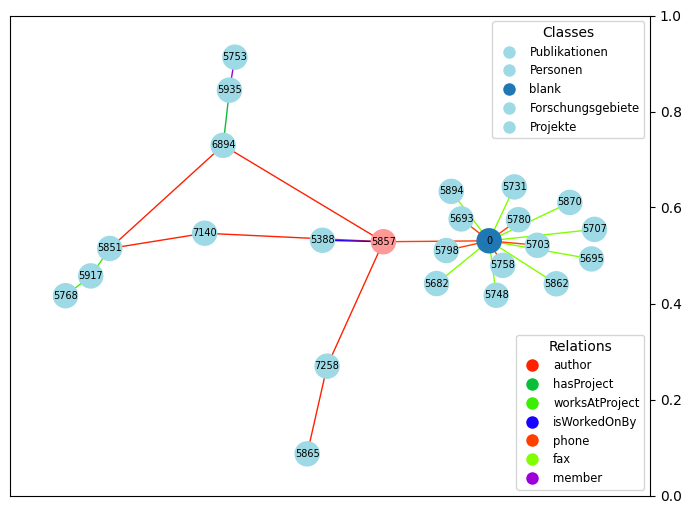

<Figure size 640x480 with 0 Axes>

In [112]:

from matplotlib import legend
from networkx import spring_layout


def connect_minimally(disconnected_triples, guideline_triples):
    G = nx.Graph()

    # Add the disconnected triples as edges to the graph
    for u,label, v in disconnected_triples:
        G.add_edge(int(u), int(v), weight=label)

    # Check if the graph is connected
    is_connected = nx.is_connected(G)
    # If the graph is not connected
    if not is_connected:
        # Get the nodes from the disconnected triples
        disconnected_nodes = set()
        for triple in disconnected_triples:
            disconnected_nodes.add(triple[0])
            disconnected_nodes.add(triple[1])

        # Create a subgraph with only the guideline triples relevant to the disconnected nodes
        subgraph = nx.Graph()
        for u,label, v in guideline_triples:
            if u in disconnected_nodes and v in disconnected_nodes:
                subgraph.add_edge(int(u), int(v), weight=label)
            


        # Compute the minimum spanning tree of the subgraph
        min_spanning_tree = nx.minimum_spanning_tree(subgraph)

        # Add the edges from the minimum spanning tree to the graph
        for u, v, weight in min_spanning_tree.edges(data='weight'):
            G.add_edge(u, v, weight=weight)



    return G


def visualize(node_idx, n_hop, data, masked_ver,masked_hor,threshold,name, result_weights=True, low_threshold=False,experiment_name=None, selected_visualization=True, connected_subgraph = True,make_connected=False):
    """ 
    Visualize important nodes for node idx prediction
    """
    get_relations(data)
    #dict_index = dict_index_classes(data,masked_ver) + dict_index_classes(data,masked_hor)
    #dict_index = {**dict_index_classes(data,masked_ver), **dict_index_classes(data,masked_hor)}
    #print(set(list(dict_index.values())))
    #select only nodes with a certain threshold
    if selected_visualization:
        sel_masked_ver, sel_masked_hor = sub_sparse_tensor(masked_ver, threshold,data, low_threshold),sub_sparse_tensor(masked_ver, threshold,data, low_threshold)

    else:
        sel_masked_ver, sel_masked_hor = masked_ver, masked_ver
    if len(sel_masked_ver)==0:
        sel_masked_ver=sub_sparse_tensor(masked_ver, 0,data, low_threshold)
    indices_nodes = sel_masked_ver.coalesce().indices().detach().numpy()
    
    G = nx.Graph()
    if result_weights: #the edge value is the mask weight       
        G.add_edges_from([(int(s), int(o), {'weight': np.round(p, 2)}) for s, p, o in zip(indices_nodes[0], sel_masked_ver.coalesce().values().tolist(), indices_nodes[1])])

    else: #the edge value is the relation
        triples_matched = match_to_triples(sel_masked_ver,sel_masked_hor, data)
        G.add_edges_from([(int(s), int(o), {'weight': p}) for s, p, o in find_repeating_sublists(triples_matched.tolist())])

    if connected_subgraph:
        G = G.subgraph(next(comp for comp in nx.connected_components(G) if node_idx in comp))

    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = [list(set([item] if not isinstance(item, list) else item)) for item in weights]


    #ordered_dict = {int(node): str(data.i2e[int(node)]).split('/')[3] for node in G.nodes if '#' not in str(data.i2e[int(node)]).split('/')[3] else str(data.i2e[int(node)]).split('/')[3][1].split('#')[1].split(',')[0].replace("'","")}
    #ordered_dict = {int(node): str(data.i2e[int(node)]).split('/')[3] if 'http' in str(data.i2e[int(node)])  else 'blank' for node in G.nodes}
    if name == 'IMDb_us':
        ordered_dict = {
            int(node): (
                str(data.i2e[int(node)]).split('/')[6].split(',')[0]
                # str(data.i2e[int(node)]).split('/')[6].split('#')[0]
                # if 'http' in str(data.i2e[int(node)]) and '#' in str(data.i2e[int(node)])
                # else str(data.i2e[int(node)]).split('/')[6]
                # if 'http' in str(data.i2e[int(node)])
                # else 'blank'
                    )
            for node in G.nodes
            }
    else:

        ordered_dict = {
        int(node): (
            str(data.i2e[int(node)]).split('/')[3].split('#')[0]
            if 'http' in str(data.i2e[int(node)]) and '#' in str(data.i2e[int(node)])
            else str(data.i2e[int(node)]).split('/')[3]
            if 'http' in str(data.i2e[int(node)])
            else 'blank'
        )
        for node in G.nodes
        }


    dict_node_color = {k: data.entities_classes[v] if v in data.entities_classes else 0 for k, v in ordered_dict.items()} 
    dict_node_color[node_idx] = 7
    print('ordered dict',ordered_dict)
    print('dict node color',dict_node_color)
    labeldict = {int(node): int(node) for node in G.nodes}

    pos = nx.circular_layout(G)
    if make_connected:
        disconnected_triples = [[i[0], j[0], i[1]] for i, j in zip(edges, weights)] + [[i[0], j[1], i[1]] for i, j in zip(edges, weights) if len(j) > 1]; guideline_triples = data.triples.tolist()
        G = connect_minimally(disconnected_triples, guideline_triples)
        #G = G.subgraph(next(comp for comp in nx.connected_components(G) if node_idx in comp))
        G = G.subgraph(next(comp for comp in nx.connected_components(G)))
        edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
        labeldict = {int(node): int(node) for node in G.nodes}
        if name == 'dbo_gender' :
            labeldict = {int(node): str(data.i2e[int(node)]).split('/')[-1].split(',')[0] for node in G.nodes}
        if name == 'IMDb_us':
            labeldict = {int(node): str(data.i2e[int(node)]).split('/')[7] for node in G.nodes}
            
        rel = {k: [v] for k, v in nx.get_edge_attributes(G, 'weight').items()}
        rel = {k: [data.i2rel[item][0] for item in v] if isinstance(v, list) else data.i2rel[v][0] for k, v in rel.items()}

        pos = nx.spring_layout(G,seed=42)
        #pos = nx.spring_layout(G,seed=5)
        #pos = nx.spring_layout(G,seed=10)
        col_weights = [weights[i] for i in range(len(weights))]

        color_map = plt.cm.get_cmap('prism')
        colors = [color_map(col_weights[i]) for i in range(len(col_weights))]
        print('colors',colors)
        label_colors = {data.i2rel[i][0]:j for i,j in zip(col_weights,colors)}
        legend_elements = []
        print('label colors',label_colors)
        for label, color in label_colors.items():
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))
        legend_elements1 = []
        cmap = plt.cm.get_cmap('tab20')
        mapped_dict2 = {key: cmap(value) for key, value in dict_node_color.items()}
        combined_dict = {ordered_dict[key]: value for key, value in mapped_dict2.items() if key in ordered_dict}
        print('combined dict',combined_dict)
        for label, color in combined_dict.items():
            legend_elements1.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))



        node_colors = [mapped_dict2[i]  if i in mapped_dict2 else cmap(0) for i in G.nodes]
        nx.draw(G, pos,labels = labeldict, edgelist=edges,node_color = node_colors  ,font_size=7, arrows = True,edge_color=[label_colors[data.i2rel[i][0]] for i in col_weights])
        #nx.draw_networkx_edge_labels( G, pos,edge_labels=rel,font_size=3,font_color='red')
        plt.legend(handles=legend_elements, loc='lower right',title= 'Relations',fontsize='small')
        ax = plt.gca().twinx()

        ax.legend(handles=legend_elements1,  title='Classes', loc='upper right',fontsize='small')


        plt.show()
        
    if result_weights==False and make_connected==False:
        col_weights = [sum(weights[i]) if len(weights[i]) > 1 else weights[i][0] for i in range(len(weights))]

        rel = {k: [data.i2rel[item][0] for item in v] if isinstance(v, list) else data.i2rel[v][0] for k, v in {k: list(set(v)) for k, v in nx.get_edge_attributes(G, 'weight').items()}.items()}
        color_map = plt.cm.get_cmap('prism')
        colors = [color_map(col_weights[i]) for i in range(len(col_weights))]
        label_colors = {data.i2rel[i][0]:j for i,j in zip(col_weights,colors)}

        legend_elements = []
        print('label colors',label_colors)
        for label, color in label_colors.items():
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))
        legend_elements1 = []
        cmap = plt.cm.get_cmap('tab20')
        mapped_dict2 = {key: cmap(value) for key, value in dict_node_color.items()}
        combined_dict = {ordered_dict[key]: value for key, value in mapped_dict2.items() if key in ordered_dict}
        print('combined dict',combined_dict)
        for label, color in combined_dict.items():
            legend_elements1.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))



        node_colors = [mapped_dict2[i]  if i in mapped_dict2 else cmap(0) for i in G.nodes]
        nx.draw(G, pos,labels = labeldict, edgelist=edges,node_color = node_colors  ,font_size=7, arrows = True,edge_color=[label_colors[data.i2rel[i][0]] for i in col_weights])
        #nx.draw_networkx_edge_labels( G, pos,edge_labels=rel,font_size=3,font_color='red')
        plt.legend(handles=legend_elements, loc='lower right',title= 'Relations',fontsize='small')
        ax = plt.gca().twinx()

        ax.legend(handles=legend_elements1,  title='Classes', loc='upper right',fontsize='small')


        plt.show()
        #legend_elements = []

        # for label, color in label_colors.items():
        #     legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))
        # #nx.draw(G, pos,labels = labeldict, edgelist=edges,node_color =  [dict_node_color[i] for i in G.nodes], cmap="Set2",font_size=7, arrows = True,edge_color=[label_colors[data.i2rel[i][0]] for i in col_weights])   
        # nx.draw(G, pos,labels = labeldict, edge_color=col_weights,edgelist=edges,node_color =  [dict_node_color[i] for i in G.nodes], cmap="Set2",font_size=7, arrows = True)
        # nx.draw_networkx_edge_labels( G, pos,edge_labels=rel,font_size=5,font_color='red')
        # plt.legend(handles=legend_elements, loc='lower right')

        # plt.show()
    if result_weights:
        col_weights = [weights[i] for i in range(len(weights))]
        nx.draw(G, pos,labels = labeldict,  edgelist=edges, edge_color=col_weights, node_color =  [dict_node_color[i] for i in G.nodes], cmap="Set2",edge_cmap=plt.cm.Reds,font_size=8)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=nx.get_edge_attributes(G,'weight'),font_size=8,font_color='red')
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array(weights)
        cbar = plt.colorbar(sm)
        cbar.ax.set_title('Weight')
        plt.title("Node {}'s {}-hop neighborhood important nodes".format(node_idx, n_hop))
        if not os.path.exists(f'chk/{name}_chk/exp/{experiment_name}⁄graphs'):
            os.makedirs(f'chk/{name}_chk/{experiment_name}⁄graphs')  
        plt.savefig(f'chk/{name}_chk/exp/{experiment_name}⁄graphs/Explanation_{node_idx}_weights.png')


    else:
        if not os.path.exists(f'chk/{name}_chk/exp/{experiment_name}⁄graphs'):
            os.makedirs(f'chk/{name}_chk/exp/{experiment_name}⁄graphs')  
        plt.savefig(f'chk/{name}_chk/exp/{experiment_name}⁄graphs/Explanation_{node_idx}_relations.png')    
        return  edges, weights


edges, weights = visualize(node_idx, n_hop, data, v_t,h_t,threshold,name, result_weights=False, low_threshold=False,experiment_name=None, selected_visualization=True,connected_subgraph=False,make_connected=True)


{'actor': 4107, 'cinematographer': 4227, 'country': 4238, 'decimal': 4259, 'director': 4267, 'editor': 4292, 'film': 4316, 'int': 4384, 'performance': 4615, 'producer': 4623, 'writer': 4795}
dict node color {8612: 4316, 13611: 0, 9025: 4316, 9111: 4316, 9159: 4316, 9245: 4316, 9255: 4316, 9313: 4316, 9477: 4316, 9528: 4316, 9719: 4316, 9729: 4316, 8564: 4316, 8501: 4238, 8601: 4316, 8653: 4316, 8662: 4316, 8767: 4316, 8941: 4316, 9145: 4316, 9563: 4316, 9609: 4316, 9547: 7}
colors [(1.0, 0.3202982932722162, 0.0, 1.0), (1.0, 0.3202982932722162, 0.0, 1.0), (1.0, 0.3202982932722162, 0.0, 1.0), (1.0, 0.3202982932722162, 0.0, 1.0), (1.0, 0.3202982932722162, 0.0, 1.0), (1.0, 0.3202982932722162, 0.0, 1.0), (1.0, 0.3202982932722162, 0.0, 1.0), (1.0, 0.3202982932722162, 0.0, 1.0), (1.0, 0.3202982932722162, 0.0, 1.0), (1.0, 0.3202982932722162, 0.0, 1.0), (1.0, 0.3202982932722162, 0.0, 1.0), (1.0, 0.3202982932722162, 0.0, 1.0), (0.24310366462004168, 0.0, 1.0, 1.0), (0.24310366462004168, 0.0, 1.0,

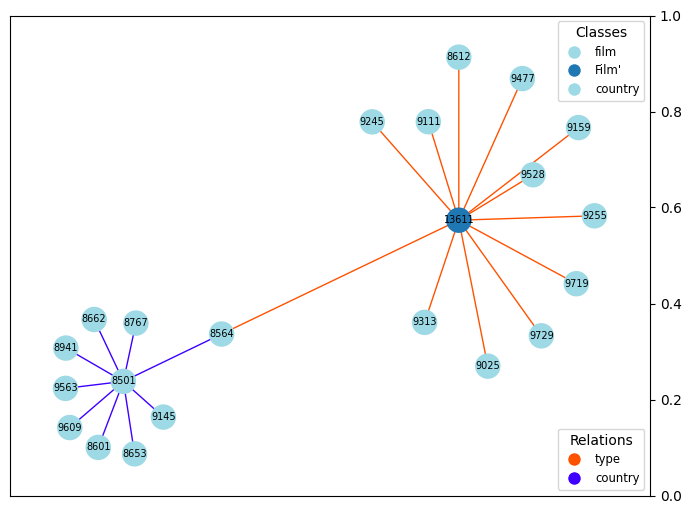

<Figure size 640x480 with 0 Axes>

In [88]:
# path = 'chk/aifb_chk/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/masked_adj'
# node_idx = 5857
# n_hop = 2
# threshold = 0.5
# name = 'aifb'
# data = kg.load(name, torch=True)
# d_classes(data)



# path = 'chk/mutag_chk/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.0005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/masked_adj'

# node_idx = 14064#4510
# n_hop = 2
# threshold = 0.5
# name = 'mutag'
# data = kg.load(name, torch=True)
# d_classes(data)

# path = '/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/dbo_gender_chk/exp/exp/init_normal_hops_2_lr_0.1_adaptive_False_size_0.0005_sizestd_adaptive_ent_1_type_1_killtype_False_break_no/masked_adj'
# node_idx = 7823#7130
# n_hop = 2
# threshold = 0.5
# name = 'dbo_gender'
# data = torch.load(f'data/DBO/finals/{name}.pt')
# data.triples = torch.Tensor(data.triples).to(int)
# data.withheld = torch.Tensor(data.withheld).to(int)
# data.training = torch.Tensor(data.training).to(int)
# d_classes(data)


path = 'chk/IMDb_us_chk/hops_2_size_5e-05_lr_0.1_ent_1_killtype_False_init_normal_exp__break_wrong_pred/masked_adj'
node_idx = 9547
n_hop = 2
threshold = 0.5
name = 'IMDb_us'
data = torch.load(f'data/IMDB/finals/{name}.pt')
data.triples = torch.Tensor(data.triples).to(int)
data.withheld = torch.Tensor(data.withheld).to(int)
data.training = torch.Tensor(data.training).to(int)
d_classes(data,name)


v = torch.load(f'{path}/masked_ver{node_idx}')
h = torch.load(f'{path}/masked_hor{node_idx}')
h_t, v_t,t,t = threshold_mask(h,v,data,20)
# v_t = convert_binary(v)
edges, weights = visualize(node_idx, n_hop, data, v_t,h_t,threshold,name, result_weights=False, low_threshold=False,experiment_name=None, selected_visualization=True,connected_subgraph=False,make_connected=True)

In [82]:
def d_classes(data,name=None):
    """ 
    Get classes of nodes (select only the alphanum - not literals)
    """
    data.entities = np.append(data.triples[:,0].tolist(),(data.triples[:,2].tolist()))
    indices_nodes = data.entities
    d = list(data.e2i.keys())
    values_indices_nodes = [d[int(i)] for i in indices_nodes]
    dict = {}
    for i in range(len(values_indices_nodes)):
        try:
            if '#' not in str(values_indices_nodes[i][1]) :
                if name == 'IMDb_us':
                    dict[values_indices_nodes[i][0]] = str(values_indices_nodes[i][1]).split('/')[6]
                else:
                    dict[values_indices_nodes[i][0]] = str(values_indices_nodes[i][1]).split('/')[3]
            if '#' in str(values_indices_nodes[i][1]):
                dict[values_indices_nodes[i][0]] = str(values_indices_nodes[i][1][1]).split('#')[1].split(',')[0].replace("'","")
            
        except IndexError :
            dict[values_indices_nodes[i][0]] = str(values_indices_nodes[i])
    
    classes = {key: value for key, value in encode_classes(dict).items() if key.isalpha()}
    data.entities_classes = classes
    print(classes)
    d = {key.item(): data.withheld[:, 0][data.withheld[:, 1] == key].tolist() for key in torch.unique(data.withheld[:, 1])}
    return d

d_classes(data, name='IMDb_us')

{'actor': 4107, 'cinematographer': 4227, 'country': 4238, 'decimal': 4259, 'director': 4267, 'editor': 4292, 'film': 4316, 'int': 4384, 'performance': 4615, 'producer': 4623, 'writer': 4795}


{0: [10112,
  10137,
  10125,
  10118,
  10113,
  10119,
  10106,
  10111,
  10117,
  10107,
  10114,
  10142,
  10130,
  10127,
  10121,
  10129,
  10140,
  10108,
  10122,
  10123,
  10136,
  10131,
  10150,
  10110,
  10120,
  10116,
  10128,
  10124,
  10109,
  10139],
 1: [9552,
  9662,
  9616,
  9718,
  9547,
  9596,
  9559,
  9635,
  9752,
  9593,
  9689,
  9735,
  9629,
  9740,
  9683,
  9733,
  9632,
  9716,
  9725,
  9582,
  9684,
  9687,
  9604,
  9627,
  9590,
  9623,
  9666,
  9631,
  9648,
  9601,
  9595,
  9569,
  9711,
  9744,
  9611,
  9619,
  9727,
  9702,
  9741,
  9535,
  9724,
  9705,
  9531,
  9679,
  9739,
  9747,
  9701,
  9557,
  9626,
  9577,
  9545,
  9563,
  9588,
  9581,
  9677,
  9675,
  9542,
  9664,
  9587,
  9589,
  9749,
  9606,
  9618,
  9567,
  9678,
  9550,
  9722,
  9586,
  9597,
  9695,
  9730,
  9543,
  9598,
  9622,
  9554,
  9602,
  9621,
  9682,
  9713,
  9743,
  9728,
  9570,
  9564,
  9714,
  9583,
  9617,
  9719,
  9572,
  9585,
  9591,
  9

In [32]:
v = torch.load(f'{path}/masked_ver{node_idx}')
v_t.coalesce().values().count_nonzero()

tensor(50)

In [56]:
data.i2e[9313]


('https://triplydb.com/Triply/linkedmdb/id/film/32872', 'iri')

In [44]:
data.i2r[9]

'http://xmlns.com/foaf/0.1/based_near'

In [321]:
def connect_minimally(disconnected_triples, guideline_triples, node):
    G = nx.Graph()

    # Add the disconnected triples as edges to the graph
    for u, label, v in disconnected_triples:
        G.add_edge(int(u), int(v), weight=label)

    # Check if the graph is connected
    is_connected = nx.is_connected(G)

    # If the graph is not connected or the given node is not present in the graph
    if not is_connected or node not in G:
        # Get the nodes from the disconnected triples
        disconnected_nodes = set()
        for triple in disconnected_triples:
            disconnected_nodes.add(triple[0])
            disconnected_nodes.add(triple[1])

        # Create a subgraph with only the guideline triples relevant to the disconnected nodes
        subgraph = nx.Graph()
        for u, label, v in guideline_triples:
            if u in disconnected_nodes and v in disconnected_nodes:
                subgraph.add_edge(int(u), int(v), weight=label)

        # Compute the minimum spanning tree of the subgraph
        min_spanning_tree = nx.minimum_spanning_tree(subgraph)

        # Add the edges from the minimum spanning tree to the graph
        for u, v, weight in min_spanning_tree.edges(data='weight'):
            G.add_edge(u, v, weight=weight)

        # Add connections to the given node with their weights
        # for u in disconnected_nodes:
        #     if u != node:
        #         weight = nx.shortest_path_length(G, source=u, target=node, weight='weight')
        #         G.add_edge(u, node, weight=weight)

    return G


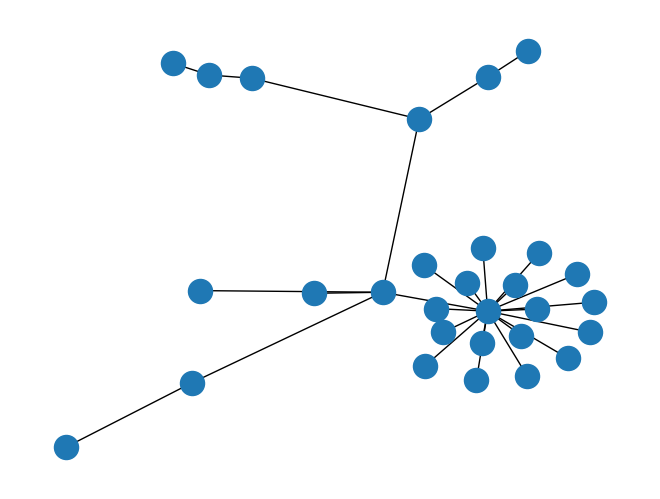

In [322]:
disconnected_triples = [[i[0], j[0], i[1]] for i, j in zip(edges, weights)] + [[i[0], j[1], i[1]] for i, j in zip(edges, weights) if len(j) > 1]; guideline_triples = data.triples.tolist()
G = connect_minimally(disconnected_triples, guideline_triples,node_idx)
G = G.subgraph(next(comp for comp in nx.connected_components(G) if node_idx in comp))
nx.draw

In [204]:
for i,j in zip(edges, weights):

    print(data.i2e[i[0]][0],',', data.i2r[j[0]],',', data.i2e[i[1]][0])
    if len(j) > 1:
        print(data.i2e[i[0]][0],',', data.i2r[j[1]],',', data.i2e[i[1]][0])

http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id1048instance , http://swrc.ontoware.org/ontology#author , http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id2055instance
http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id1048instance , http://swrc.ontoware.org/ontology#publication , http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id2055instance
http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id1048instance , http://swrc.ontoware.org/ontology#author , http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id2097instance
http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id2055instance , http://swrc.ontoware.org/ontology#author , http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id1164instance
http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id2055instance , http://swrc.ontoware.org/ontology#publication , http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id795instance
http:/

In [149]:
v = torch.load(f'{path}/masked_ver_thresh{node_idx}')
h.coalesce().values().count_nonzero()

tensor(0)

In [124]:
v_t.coalesce().values().count_nonzero()

tensor(0)

loaded data mutag (0.3741s).
{(5916, 13116): [1, 1], (13116, 7579): [1, 1], (13116, 20982): [1, 1], (13116, 442): [4, 4], (13116, 5198): [4, 4], (13116, 12773): [4, 4], (13116, 21167): [4, 4], (13116, 23059): [4, 4], (13116, 11190): [18, 18], (13116, 19216): [18, 18], (1545, 23076): [11, 11], (23076, 6875): [11, 11], (23076, 18610): [11, 11], (4510, 20225): [14, 14], (4510, 7991): [20, 20]}


/usr/local/Caskroom/miniconda/base/envs/RGCNExplainer/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


15


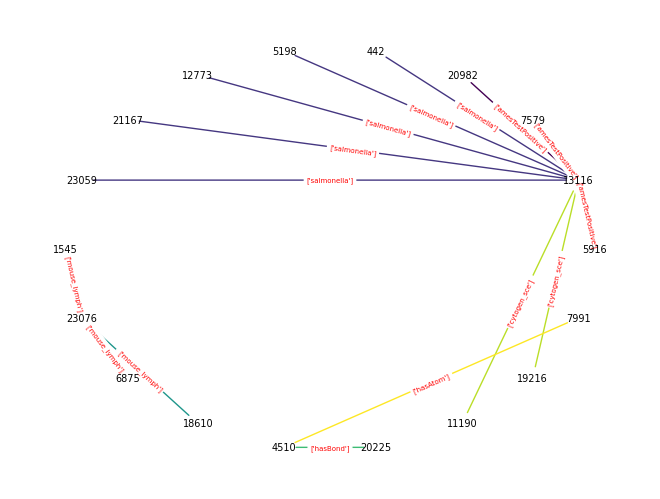

In [140]:
#path = 'chk/aifb_chk/exp/init_normal_hops_2_lr_0.1_adaptive_False_size_5e-05_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/masked_adj'
#path = 'chk/aifb_chk/exp/init_normal_hops_2_lr_0.1_adaptive_False_size_5e-05_sizestd_adaptive_ent_10_type_-1_killtype_False_break_no/masked_adj'
#path = 'chk/aifb_chk/exp/init_overall_frequency_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/masked_adj'
path = 'chk/mutag_chk/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.0005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/masked_adj'

node_idx = 4510
n_hop = 2
threshold = 0.5
name = 'mutag'
data = kg.load(name, torch=True)
d_classes(data)


v = torch.load(f'{path}/masked_ver{node_idx}')
h = torch.load(f'{path}/masked_hor{node_idx}')
h_t, v_t,t_h, t_v = threshold_mask(h,v,data,15)
edges, weights = visualize(node_idx, n_hop, data, v_t,threshold,name, result_weights=False, low_threshold=False,experiment_name=None, selected_visualization=True,connected_subgraph=False)
selected_triples = []
for i,j in zip(edges, weights):
    selected_triples.append([i[0], j[0], i[1]])
    if len(j) > 1:
        selected_triples.append([data.i2e[i[0]][0], data.i2r[j[1]], data.i2e[i[1]][0]])
selected_triples
print(len(selected_triples))

{(8233, 3077): [0, 0], (8233, 4689): [0, 0], (8233, 854): [217, 217], (7186, 2028): [217, 217], (2028, 7278): [217, 217], (2028, 7284): [217, 217], (2028, 7378): [217, 217], (2028, 7472): [217, 217], (2028, 7524): [217, 217], (2028, 7584): [217, 217], (2028, 7696): [217, 217], (2028, 7729): [217, 217], (2028, 7963): [217, 217], (2028, 7975): [217, 217], (2028, 8175): [217, 217]}


/usr/local/Caskroom/miniconda/base/envs/RGCNExplainer/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


(((8233, 3077),
  (8233, 4689),
  (8233, 854),
  (7186, 2028),
  (2028, 7278),
  (2028, 7284),
  (2028, 7378),
  (2028, 7472),
  (2028, 7524),
  (2028, 7584),
  (2028, 7696),
  (2028, 7729),
  (2028, 7963),
  (2028, 7975),
  (2028, 8175)),
 [[0],
  [0],
  [217],
  [217],
  [217],
  [217],
  [217],
  [217],
  [217],
  [217],
  [217],
  [217],
  [217],
  [217],
  [217]])

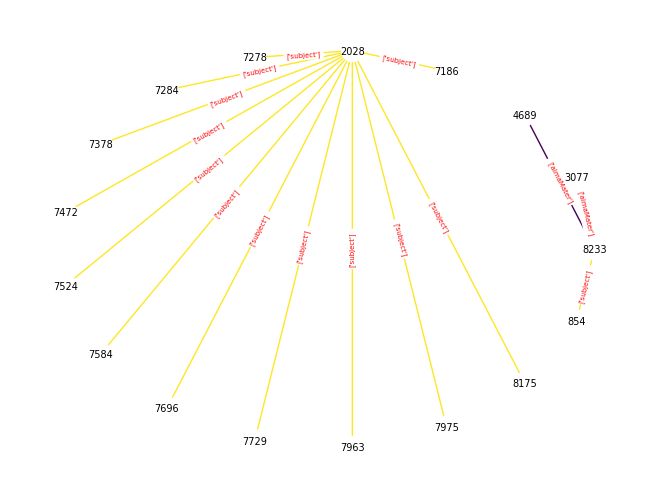

In [139]:
path = 'chk/dbo_gender_chk/exp/exp/init_normal_hops_2_lr_0.1_adaptive_False_size_0.0005_sizestd_adaptive_ent_1_type_1_killtype_False_break_no/masked_adj'

node_idx = 8233#6435
n_hop = 2
threshold = 0.5
name = 'dbo_gender'
if name in ['aifb', 'mutag', 'bgs', 'am', 'mdgenre']:
    data = kg.load(name, torch=True, final=False)
if 'IMDb' in name:    
    data = torch.load(f'data/IMDB/finals/{name}.pt')
if 'dbo' in name:
    data = torch.load(f'data/DBO/finals/{name}.pt')
data.triples = torch.Tensor(data.triples).to(int)
data.withheld = torch.Tensor(data.withheld).to(int)
data.training = torch.Tensor(data.training).to(int)
d_classes(data)
get_relations(data)
relations = list(set([data.i2rel[i][0] for i in range(len(data.i2rel))]))
relations

v = torch.load(f'{path}/masked_ver{node_idx}')
h = torch.load(f'{path}/masked_hor{node_idx}')
h_t, v_t,t_h, t_v = threshold_mask(h,v,data,15)
visualize(node_idx, n_hop, data, v_t,threshold,name, result_weights=False, low_threshold=False,experiment_name=None, selected_visualization=True,connected_subgraph=False)

In [15]:

for i in data.withheld:
    if i[0] == node_idx:
        print(i)

tensor([6435,    0])


In [293]:

def connect_minimally(disconnected_triples, guideline_triples):
    G = nx.Graph()

    # Add the disconnected triples as edges to the graph
    for u,label, v in disconnected_triples:
        G.add_edge(int(u), int(v), weight=label)

    # Check if the graph is connected
    is_connected = nx.is_connected(G)
    # If the graph is not connected
    if not is_connected:
        # Get the nodes from the disconnected triples
        disconnected_nodes = set()
        for triple in disconnected_triples:
            disconnected_nodes.add(triple[0])
            disconnected_nodes.add(triple[1])

        # Create a subgraph with only the guideline triples relevant to the disconnected nodes
        subgraph = nx.Graph()
        for u,label, v in guideline_triples:
            if u in disconnected_nodes and v in disconnected_nodes:
                subgraph.add_edge(int(u), int(v), weight=label)
            


        # Compute the minimum spanning tree of the subgraph
        min_spanning_tree = nx.minimum_spanning_tree(subgraph)

        # Add the edges from the minimum spanning tree to the graph
        for u, v, weight in min_spanning_tree.edges(data='weight'):
            G.add_edge(u, v, weight=weight)



    return G


def visualize(node_idx, n_hop, data, masked_ver,threshold,name, result_weights=True, low_threshold=False,experiment_name=None, selected_visualization=True, connected_subgraph = True,make_connected=False):
    """ 
    Visualize important nodes for node idx prediction
    """
    get_relations(data)
    dict_index = dict_index_classes(data,masked_ver)
    
    #select only nodes with a certain threshold
    if selected_visualization:
        sel_masked_ver = sub_sparse_tensor(masked_ver, threshold,data, low_threshold)
        sel_masked_hor = sub_sparse_tensor(masked_ver, threshold,data, low_threshold)
    else:
        sel_masked_ver = masked_ver
        sel_masked_hor = masked_ver
    if len(sel_masked_ver)==0:
        sel_masked_ver=sub_sparse_tensor(masked_ver, 0,data, low_threshold)
    indices_nodes = sel_masked_ver.coalesce().indices().detach().numpy()
    new_index = np.transpose(np.stack((indices_nodes[0], indices_nodes[1]))) #original edge indexes

    
    
    G = nx.Graph()
    if result_weights:
        values = sel_masked_ver.coalesce().values().tolist()
        for s,p,o in zip(indices_nodes[0],values , indices_nodes[1]):
            G.add_edge(int(s), int(o), weight=np.round(p, 2))

    else:

        triples_matched = match_to_triples(sel_masked_ver,sel_masked_hor, data)
        l = []
        for i in triples_matched[:,1]:
            l.append(data.i2rel[int(i)][0])
        triples_matched = find_repeating_sublists(triples_matched.tolist())
        for s,p,o in triples_matched:
            G.add_edge(int(s), int(o), weight=p)
    if connected_subgraph:
        #conncected subgraph
        #add condition to take node of interest for the connected boy
        
        # connected_components = nx.connected_components(G)
        # component = next(connected_components)
        # G = G.subgraph(component)

        connected_components = nx.connected_components(G)

        component = None
        for comp in connected_components:
            if node_idx in comp:
                component = comp
                break

        if component is not None:
            # Extract the subgraph containing the specified node
            G = G.subgraph(component)

    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = [[item] if not isinstance(item, list) else item for item in weights]
    weights = [list(set(w)) for w in weights]



    pos = nx.circular_layout(G)
    #pos = nx.spring_layout(G)

    ordered_dict = {}
    for item in list(G.nodes):

        if item in ordered_dict:
            ordered_dict[item].append(dict_index[item])

        # if item not in ordered_dict and item in dict_index:
        #     ordered_dict[item] =  dict_index[item]
        # if item not in dict_index:
        #     ordered_dict[item] = 100000


    dict_index = ordered_dict

    labeldict = {}
    for node in G.nodes:
        labeldict[int(node)] = int(node)  

    dict = {}
    for k,v in dict_index.items():
        for k1,v1 in data.entities_classes.items():
            if v==k1: 

                dict[k] = v1
                print(v1)
            else:
                if k not in dict:
                    dict[k] = 0
                

    color_list = list(dict.values())
    #color_list = list(encode_dict(dict_index).values())

    if make_connected:
        disconnected_triples = []
        for i,j in zip(edges, weights):
            disconnected_triples.append([i[0], j[0], i[1]])
            if len(j) > 1:
                disconnected_triples.append(i[0], j[1], i[1])
        guideline_triples = data.triples.tolist()

        G = connect_minimally(disconnected_triples, guideline_triples)
        edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
 

        pos = nx.spring_layout(G)
        re = nx.get_edge_attributes(G, 'weight')
        rel = {k: [v] for k, v in re.items()}

        for k, v in rel.items():
            if isinstance(v, list):
                updated_values = [data.i2rel[item][0] for item in v]
                rel[k] = updated_values
            else:
                rel[k] = data.i2rel[v][0]

        labeldict = {}
        for node in G.nodes:
            labeldict[int(node)] = int(node) 
        col_weights = [weights[i] for i in range(len(weights))]
        nx.draw(G, pos,labels = labeldict, edge_color=col_weights,edgelist=edges,node_color =  color_list, cmap="Set2",font_size=7, arrows = True)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=rel,font_size=3,font_color='red')
    if result_weights:
        col_weights = [weights[i] for i in range(len(weights))]
        nx.draw(G, pos,labels = labeldict,  edgelist=edges, edge_color=col_weights, node_color =  color_list, cmap="Set2",edge_cmap=plt.cm.Reds,font_size=8)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=nx.get_edge_attributes(G,'weight'),font_size=8,font_color='red')
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array(weights)
        cbar = plt.colorbar(sm)
        cbar.ax.set_title('Weight')
        plt.title("Node {}'s {}-hop neighborhood important nodes".format(node_idx, n_hop))
    if result_weights==False and make_connected==False:
        col_weights = [sum(weights[i]) if len(weights[i]) > 1 else weights[i][0] for i in range(len(weights))]
        re = nx.get_edge_attributes(G, 'weight')
        if make_connected:
            rel = {k: [v] for k, v in re.items()}
        else:
            rel =  {k: list(set(v)) for k, v in re.items()}


        for k, v in rel.items():
            if isinstance(v, list):
                updated_values = [data.i2rel[item][0] for item in v]
                rel[k] = updated_values
            else:
                rel[k] = data.i2rel[v][0]

        col_weights = [sum(weights[i]) if len(weights[i]) > 1 else weights[i][0] for i in range(len(weights))]
        nx.draw(G, pos,labels = labeldict, edge_color=col_weights,edgelist=edges,node_color =  color_list, cmap="Set2",font_size=7, arrows = True)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=rel,font_size=5,font_color='red')
        
        res = Counter(unnest_list(rel.values()))
    if result_weights:
        if not os.path.exists(f'chk/{name}_chk/{experiment_name}⁄graphs'):
            os.makedirs(f'chk/{name}_chk/{experiment_name}⁄graphs')  
        plt.savefig(f'chk/{name}_chk/{experiment_name}⁄graphs/Explanation_{node_idx}_weights.png')

        #plt.show()

    else:
        if not os.path.exists(f'chk/{name}_chk/{experiment_name}⁄graphs'):
            os.makedirs(f'chk/{name}_chk/{experiment_name}⁄graphs')  
        plt.savefig(f'chk/{name}_chk/{experiment_name}⁄graphs/Explanation_{node_idx}_relations.png')    
        #plt.show()
        return  edges, weights





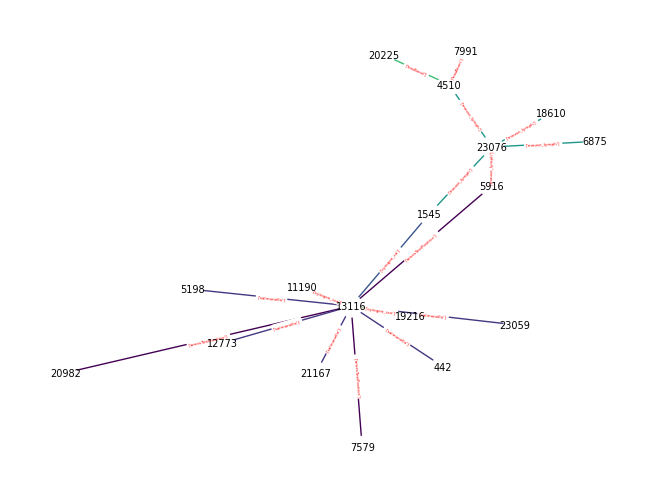

In [214]:
edges, weights = visualize(node_idx, n_hop, data, v_t,threshold,name, result_weights=False, low_threshold=False,experiment_name=None, selected_visualization=True,connected_subgraph=False,make_connected=True)

Counter({'author': 2, 'isWorkedOnBy': 2, 'member': 1, 'publication': 1})


/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


Counter({'author': 2, 'isWorkedOnBy': 2, 'member': 1, 'publication': 1})

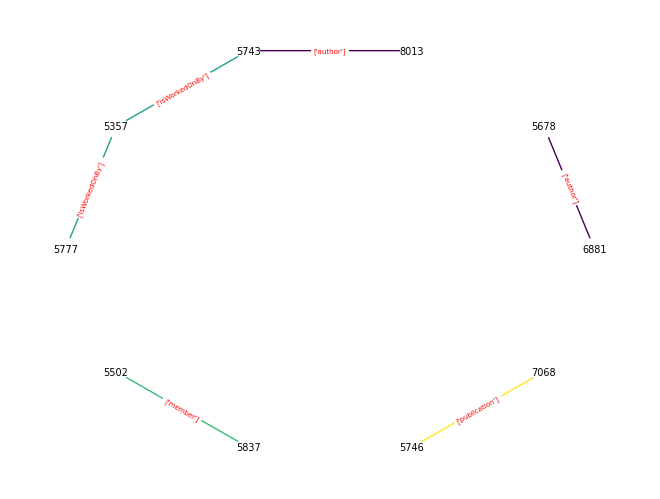

In [42]:
visualize(node_idx, n_hop, data, v,threshold,name, result_weights=False, low_threshold=False,experiment_name=None, selected_visualization=True, connected_subgraph=False)